# Exploratory Analysis

I choose the simplest application with the nutriscore : Predict it for non-label aliments. My main question will be about the robustess of my missing data inference. I read about this score [on this official document](https://www.santepubliquefrance.fr/media/files/02-determinants-de-sante/nutrition-et-activite-physique/nutri-score/qr-scientifique-technique) (on "sante public france" [website](https://www.santepubliquefrance.fr/determinants-de-sante/nutrition-et-activite-physique/articles/nutri-score))

In [1]:
data_path = "/home/clairegayral/Documents/openclassroom/data/"

# On importe les librairies dont on aura besoin pour ce tp
import numpy as np
import pandas as pd
import sklearn
## plot : 
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = [15, 5]
import seaborn as sns
## stat / model : 
from sklearn.model_selection import train_test_split

import itertools as IT

In [2]:
data = pd.read_csv(data_path+"projet2/cleanned_dataframe.csv",  index_col =0)
data_std = pd.read_csv(data_path+"projet2/cleanned_std_dataframe.csv",  index_col =0)

# 1. Nutri-score analysis : 

# 1.1 Univariate analysis : Nutri-score as a numerical variable

Let's first see the description statistics on the variable : 

In [3]:
y = data["nutrition-score-fr_100g"].copy()
y.describe()

count    9969.000000
mean        9.115558
std         8.883424
min       -14.000000
25%         1.000000
50%        10.000000
75%        16.000000
max        37.000000
Name: nutrition-score-fr_100g, dtype: float64

So it takes values between {{min(y)}} and {{max(y)}}, it is well-centered : the mean (={{y.mean()}}) is close to the median value (={{y.quantile(0.5)}}

Text(0.5, 1.0, 'nutrition-score')

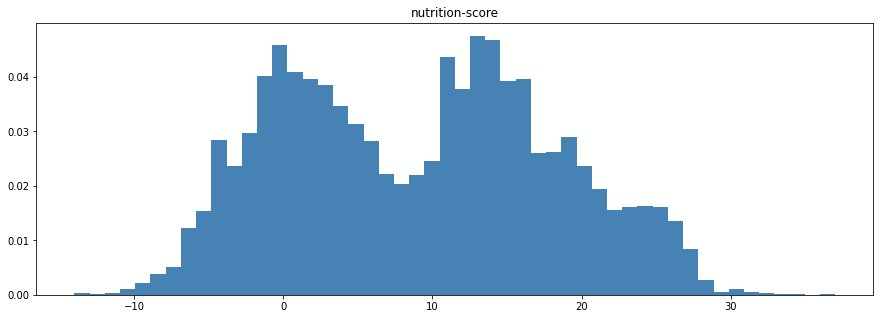

In [4]:
nb_bins = len(np.unique(y.dropna().values))
plt.hist(y, bins = nb_bins, color='steelblue', density=True, edgecolor='none')
plt.title("nutrition-score")

This varible as both negative and positive values, but I still look at the Lorenz curve and AUC, after rescaling y with a min-translatation : 

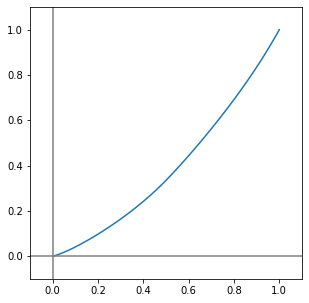

In [5]:
## lorenz curve : 
import numpy as np

n = len(y)
y_rescaled = y - min(y)
lorenz = np.cumsum(np.sort(y_rescaled)) / y_rescaled.sum()
lorenz = np.append([0],lorenz) # La courbe de Lorenz commence à 0

fig, ax = plt.subplots()

ax.axis('scaled')
xaxis = np.linspace(0-1/n,1+1/n,n+1) 
plt.plot(xaxis,lorenz,drawstyle='steps-post')
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.plot([0,0],[-0.1,1.1], color="grey") # y axis 
plt.plot([-0.1,1.1],[0,0], color="grey") # x axis

plt.show()

AUC = (lorenz.sum() -lorenz[-1]/2 -lorenz[0]/2)/n # Surface sous la courbe de Lorenz. Le premier segment (lorenz[0]) est à moitié en dessous de 0, on le coupe donc en 2, on fait de même pour le dernier segment lorenz[-1] qui est à moitié au dessus de 1.
S = 0.5 - AUC # surface entre la première bissectrice et le courbe de Lorenz
gini = 2*S

The AUC is {{np.round(AUC,2)}}, that means that ... .
Futhermore, the gini indice is {{np.round(gini,2)}}

**write the interpretation + solve affichage variable in markedown**
https://openclassrooms.com/fr/courses/4525266-decrivez-et-nettoyez-votre-jeu-de-donnees/4730366-familiarisez-vous-avec-les-mesures-de-concentration

## 1.2 Qualitative data analysis : Transform score into letter

Now, the document allow us to transform this score variable into the corresponding score letter : 

In [6]:
tmp = pd.DataFrame(columns = ["score","min_liquide","max_liquide","min_solide","max_solide"])
tmp["score"] = ["A", "B", "C", "D", "E"]
tmp["min_liquide"] = [np.nan,-100,2,6,10]
tmp["max_liquide"] = [np.nan, 1, 5, 9, 100]
tmp["min_solide"] = [-100,0,3,11,19]
tmp["max_solide"] = [-1,2,10,18,100]
tmp.score = tmp.score.astype("category")

As the nature (liquide or solid) of the product is a main element to determine that score, it would be better to **find a way to classify liquid and solid products**
I think that is a property we may deduce from the text description variable, and I do not have the time for this project to go that far. So I'll just compute the letter corresponding to solid scores, as an approximation. 

In [7]:
def transform_score_letter(product_score):
    ref_max = pd.Series([-1,2,10,18,100], 
                        index=["A", "B", "C", "D", "E"],
                        dtype = "float")
    return(ref_max[(product_score <= ref_max)].index[0])

letter_score = [transform_score_letter(y.iloc[i]) for i in range(len(y))]
letter_score = pd.Series(letter_score, dtype="category", index = y.index, name="score")

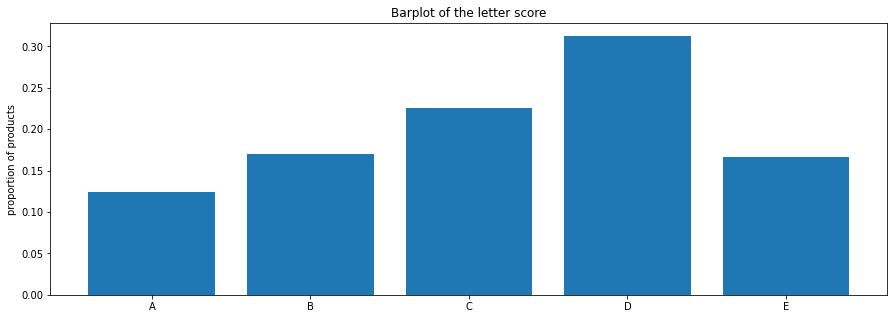

In [8]:
letter_count = letter_score.value_counts()/letter_score.count()
labels = ['A', 'B', 'C', 'D', 'E']
plt.bar(labels, letter_count[labels])
plt.title("Barplot of the letter score")
plt.ylabel("proportion of products")
plt.show()

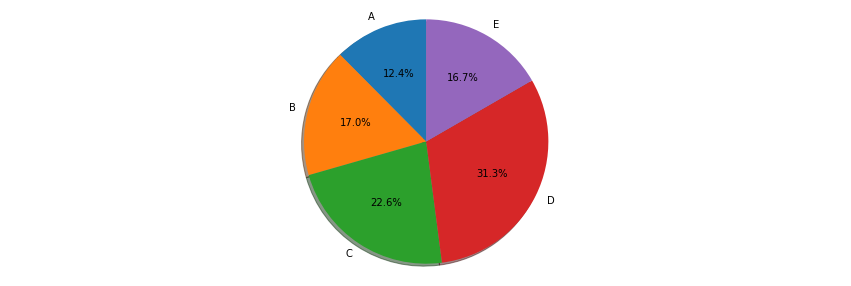

In [9]:
fig1, ax1 = plt.subplots()
ax1.pie(letter_count[labels], #explode=0.1*np.ones(len(labels)),
        labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

Let's integrate this categorical information to our numerical data :

In [10]:
description_var = ['code', 'countries', 'creator', 'product_name']
float_var = ['additives_n', 'ingredients_from_palm_oil', 'energy-kcal_100g',
             'energy_100g', 'fat_100g', 'saturated-fat_100g', 'trans-fat_100g',
             'cholesterol_100g', 'carbohydrates_100g', 'sugars_100g',
             'fiber_100g', 'proteins_100g', 'sodium_100g', 'vitamin-a_100g',
             'vitamin-c_100g', 'calcium_100g', 'iron_100g',
             'nutrition-score-fr_100g']
data2 = pd.concat([letter_score, data[data.columns.intersection(float_var)]], axis = 1)
data2.head()

,score,additives_n,ingredients_from_palm_oil,energy-kcal_100g,energy_100g,fat_100g,saturated-fat_100g,trans-fat_100g,cholesterol_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,sodium_100g,vitamin-a_100g,vitamin-c_100g,calcium_100g,iron_100g,nutrition-score-fr_100g
246189,D,0.0,3.469447e-18,560.0,2343.0,44.00,24.00,0.0,0.000,52.00,36.00,12.00,8.0,0.012,0.000013,0.00450,0.08000,7.200000e-03,18.0
320939,C,0.3,3.469447e-18,368.0,1540.0,8.80,0.80,0.0,0.000,65.00,53.00,6.18,6.8,0.080,0.000182,0.01501,0.06930,3.105000e-03,5.0
191348,D,5.0,3.469447e-18,419.0,1753.0,35.48,4.84,0.0,0.048,22.58,19.35,0.00,0.0,0.484,0.000000,0.00000,0.00000,-2.168404e-19,18.0
331844,D,0.0,3.469447e-18,900.0,3766.0,100.00,11.00,0.0,0.000,0.50,0.50,0.00,0.5,0.004,0.000010,0.00000,0.00072,3.000000e-07,11.0
189487,D,1.0,3.469447e-18,367.0,1536.0,40.00,5.00,0.0,0.000,3.33,0.00,0.00,0.0,0.967,0.000061,0.00160,0.13300,2.000000e-04,18.0


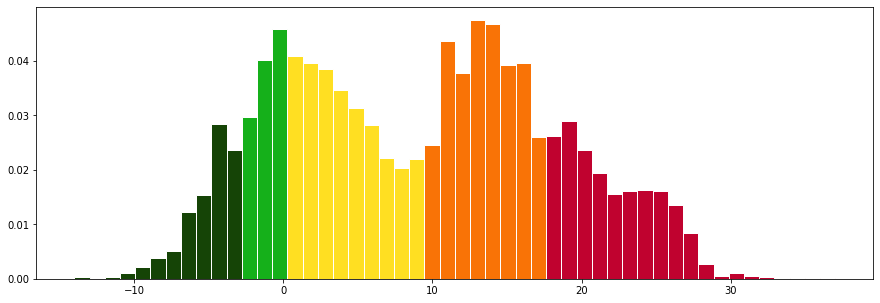

In [11]:
nb_bins = len(np.unique(y.dropna().values))
my_color_set = ['#154406', '#15b01a', '#ffdf22', '#f97306', '#c0022f',
                '#0343df', '#fe02a2', '#8b3103', '#7e1e9c', '#017371',
                '#380282', '#6b8ba4', '#75bbfd', '#ff81c0', '#c79fef',
                '#ff073a', '#fdaa48', '#fea993', '#fe7b7c', '#c20078',
                '#029386', '#677a04', '#b25f03', '#070d0d', '#ffdf22']
N, bins, patches = plt.hist(data2["nutrition-score-fr_100g"], bins = nb_bins, density=True, edgecolor='white')

## add coloration on histogram : 
limit_bins = [-1,2,10,18, data2["nutrition-score-fr_100g"].max()] - data2["nutrition-score-fr_100g"].min()
my_min = 0
k = 0
for my_max in limit_bins :
    my_max = int(my_max - 1) 
    for i in range(my_min,my_max):
        patches[i].set_facecolor(my_color_set[k])
    my_min = my_max
    k += 1

# 2. Multivariate Analysis  
## 2.1 Correlation Matrix :
Let us first of all see if the variable are correlated : 

In [12]:
def plot_corr_heatmap(corr): 
    ax = sns.heatmap(
        corr, 
        vmin=-1, vmax=1, center=0,
        cmap=sns.diverging_palette(20, 220, n=200),
        square=True
    )
    ax.set_xticklabels(
        ax.get_xticklabels(),
        rotation=45,
        horizontalalignment='right'
    );

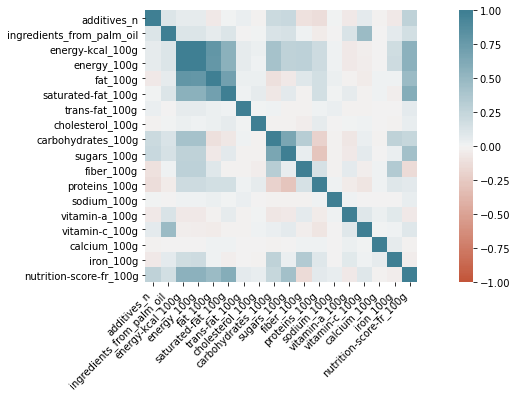

In [13]:
corr = data2.corr()
plot_corr_heatmap(corr)

Let's sort the correlation index by the values in the nutrition score : 

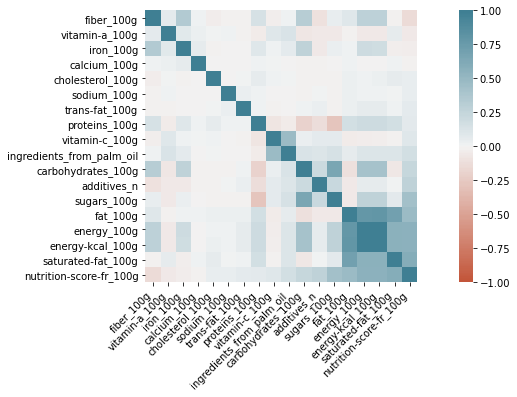

In [14]:
sorted_corr = corr.sort_values(by="nutrition-score-fr_100g", ascending = True)
sorted_corr = sorted_corr.sort_values(by="nutrition-score-fr_100g", axis = 1, ascending = True)
plot_corr_heatmap(sorted_corr)

There seems to be a cluster of correlated variable conserning fat and energy, and the other variables does not seem so correlated. 

## 2.2 Dimension Reduction with PCA : 

If it's the case, computing a PCA. 
Note that most of this code is an adapation of [the TP code proposed in the OC class](https://openclassrooms.com/fr/courses/4525281-realisez-une-analyse-exploratoire-de-donnees/5345201-tp-realisez-une-acp). 

In [238]:
from functions import *
from sklearn import decomposition
from sklearn import preprocessing

# choix du nombre de composantes à calculer
n_comp = 6

# selection des colonnes à prendre en compte dans l'ACP
X = data2.drop(["score","nutrition-score-fr_100g"],axis = 1, inplace = False)

# préparation des données pour l'ACP
scores = np.intc(data2["nutrition-score-fr_100g"]) # ou data.index pour avoir les intitulés
features = data2.columns

# Centrage et Réduction
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

# Calcul des composantes principales
pca = decomposition.PCA(n_components=n_comp)
pca.fit(X_scaled)

PCA(n_components=6)

Let's see the explained variance each new component brings : 

In [16]:
##################################################

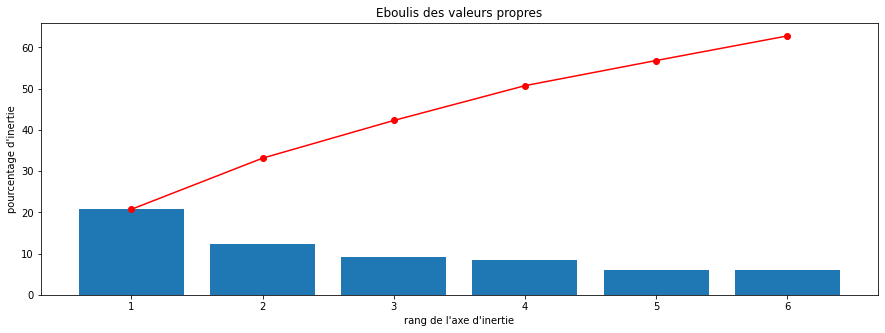

In [17]:
# Eboulis des valeurs propres
display_scree_plot(pca)

The first axe explaines 20% of the variance, and the second 12.5%. That is really low, I think that it's relevant to use our knowlegde about the cluster of "fat" variables to gather them before doing the global pca. 

### 2.2.1. Focus on PCA variables : 

To be sure, let's see the correlation circle and the projected cloud of the products in the two firsts axis :

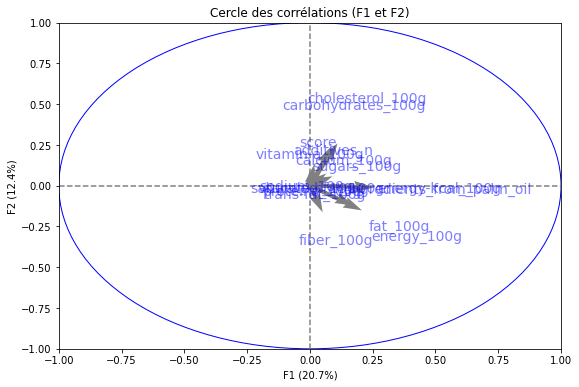

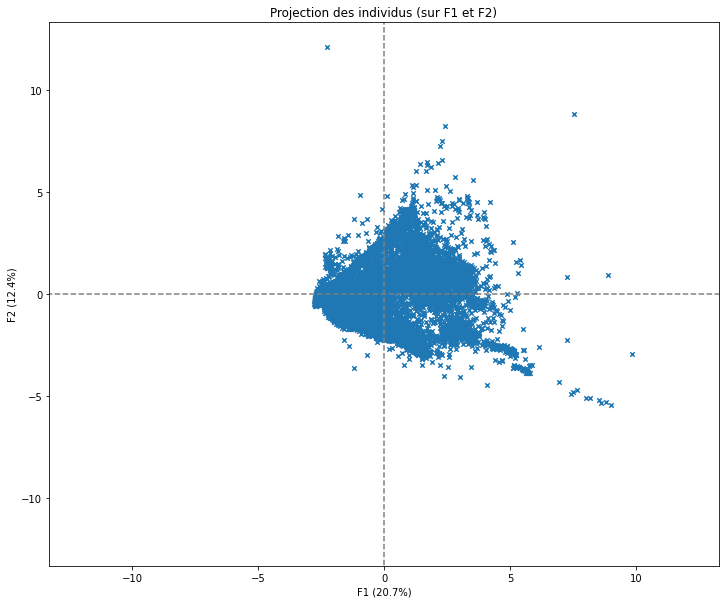

In [18]:
# Cercle des corrélations
pcs = pca.components_
display_circles(pcs, 2, pca, [(0,1)], labels = np.array(features))

# Projection des individus
X_projected = pca.transform(X_scaled)
X_projected = pd.DataFrame(X_projected, index = X.index, 
                           columns = ["Axis"+ str(k) for k in np.arange(1,X_projected.shape[1]+1)])

display_factorial_planes(X_projected, 2, pca, [(0,1)])
plt.show()

In [19]:
# pcs = pd.DataFrame(pcs, index = ["Axis"+ str(k) for k in np.arange(1,n_comp+1)],
#              columns=X.columns)
# X_projected = pd.DataFrame(X_projected, index = X.index, columns = ["Axis"+ str(k) for k in np.arange(1,n_comp+1)])

It is hard to distinguish the too close variables. I go back to my idea of a hierarchical clustering on variables to first gather the ones with same comportement. Same as before, I mostly adapt the code from [the corresponding OC course](https://openclassrooms.com/fr/courses/4525281-realisez-une-analyse-exploratoire-de-donnees/5345241-tp-partitionnez-vos-donnees).

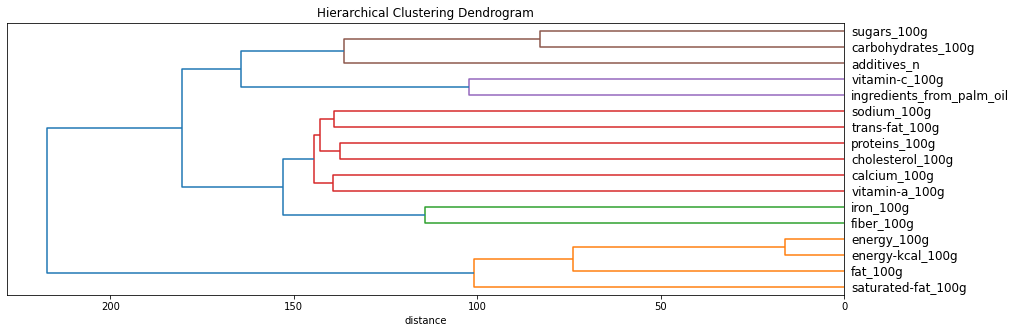

In [20]:
from scipy.cluster.hierarchy import linkage, fcluster

# Clustering hiérarchique
Z = linkage(X_scaled.transpose(), 'ward')

# Affichage du dendrogramme
plot_dendrogram(Z, X.columns, figsize = (15,5))

I modified the function to draw pca corr circle, so that I can put some clustering colors on the arrows, and print the corresponding legend : 

In [21]:
def get_str_vars(list_of_var):
    # from a list of str, return a sentence
    # if the line is too long (sup to 40), cut
    tmp = list_of_var.copy()
    res = ""
    len_line = 0
    while tmp : 
        var = tmp.pop()
        res = res+ var +str(", ")
        len_line += len(var)
        if len_line > 40:
            res = res +"\n"
            len_line = 0
    return(res)

def draw_cluster_legend(ax2,clustering, corresp_color_dict):
    ## plot the legend with colored arrow
    # number of clusters : 
    K = len(clustering.values.categories)
    my_color = clustering.values.categories.map(corresp_color_dict)
    # plot parallel arrows :
    ax2.quiver(np.zeros(K),np.arange(0,K),np.ones(K),np.zeros(K),
               color = my_color)
    # plot legend text next to the respective arrow :
    for k in clustering.values.categories :
        cluster_var = get_str_vars(list(clustering[clustering == k].index.values))
        ax2.text(0.2, k , str(cluster_var), fontsize='11',
                 ha='left', va='center' , alpha=1)
    # set limits : 
    ax2.set_xlim([-0.1,2])
    ax2.set_ylim([-1.1, K+0.1])
    ax2.set_title("Clustering legend")
    # remove axis :
    ax2.get_xaxis().set_visible(False)
    ax2.get_yaxis().set_visible(False)
    plt.axis("off")
    return(ax2)

# fig2, ax2 = plt.subplots(1,1)
# draw_cluster_legend(ax2, cluster)
# plt.show()

def display_circles(pcs, n_comp, pca, axis_ranks, labels=None, label_rotation=0, lims=None, clustering = None):
    ## set coloration palette : 
    if clustering is not None : 
        my_color_set = ['#154406', '#15b01a', '#f97306', '#c0022f',
                        '#0343df', '#fe02a2', '#8b3103', '#7e1e9c', '#017371',
                        '#380282', '#6b8ba4', '#75bbfd', '#ff81c0', '#c79fef',
                        '#ff073a', '#fdaa48', '#fea993', '#fe7b7c', '#c20078',
                        '#029386', '#677a04', '#b25f03', '#070d0d', '#ffdf22']
        corresp_color_dict = dict(zip(clustering.values.categories, my_color_set))
        my_color = clustering.values.map(corresp_color_dict)

    else : 
        my_color = "grey"
    ## set global plot arguments : 
    plot_kwargs = {"alpha":1, "color":my_color}
    ## draw the correlation circle for pca : 
    for d1, d2 in axis_ranks: # On affiche les 3 premiers plans factoriels, donc les 6 premières composantes
        if d2 < n_comp:
            ## initialise figure
            if clustering is not None : 
                fig = plt.figure(figsize = (18,6))
                ## affichage de la legende du clustering en couleur : 
                ax2 = fig.add_subplot(1,2,2)
                draw_cluster_legend(ax2, clustering, corresp_color_dict)
                # initialisation de la figure "cercle"
                ax1 = fig.add_subplot(1,2,1)
            else : 
                fig = plt.figure(figsize = (9,6))
                ax1 = fig.add_subplot(1,1,1)

            ## détermination des limites du graphique
            if lims is not None :
                xmin, xmax, ymin, ymax = lims
            elif pcs.shape[1] < 30 :
                xmin, xmax, ymin, ymax = -1, 1, -1, 1
            else :
                xmin, xmax, ymin, ymax = min(pcs[d1,:]), max(pcs[d1,:]), min(pcs[d2,:]), max(pcs[d2,:])

            ## affichage des fleches :
            if pcs.shape[1] < 30 :
                ax1.quiver(np.zeros(pcs.shape[1]), np.zeros(pcs.shape[1]), ## depart points
                           pcs[d1,:], pcs[d2,:], ## movement in each direction
                           angles='xy', scale_units='xy',**plot_kwargs)
                # (voir la doc : https://matplotlib.org/api/_as_gen/matplotlib.pyplot.quiver.html)
            else: # s'il y a plus de 30 flèches, on n'affiche pas le triangle à leur extrémité
                lines = [[[0,0],[x,y]] for x,y in pcs[[d1,d2]].T]
                ax1.add_collection(LineCollection(lines, axes=ax, alpha=.1, color=my_color))

            ## affichage des noms des variables  
            if labels is not None:  
                for i,(x, y) in enumerate(pcs[[d1,d2]].T):
                    if x >= xmin and x <= xmax and y >= ymin and y <= ymax :
                        ax1.text(x, y, labels[i], fontsize='14', ha='center', 
                                 va='center', rotation=label_rotation, color="blue", alpha=0.5)

            ## affichage du cercle
            circle = plt.Circle((0,0), 1, facecolor='none', edgecolor='b')
            plt.gca().add_artist(circle)

            ## définition des limites du graphique
            ax1.set_xlim(xmin, xmax)
            ax1.set_ylim(ymin, ymax)

            ## affichage des lignes horizontales et verticales
            plt.plot([-1, 1], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-1, 1], color='grey', ls='--')

            ## nom des axes, avec le pourcentage d'inertie expliqué
            ax1.set_xlabel('F{} ({}%)'.format(d1+1, 
                                round(100*pca.explained_variance_ratio_[d1],1)))
            ax1.set_ylabel('F{} ({}%)'.format(d2+1, 
                                round(100*pca.explained_variance_ratio_[d2],1)))
            ax1.set_title("Cercle des corrélations (F{} et F{})".format(d1+1, d2+1))
    plt.show(block=False)

I let this code here as asked for the project, but I copied it in the "functions.py" file. Let's lauch this on our pca : 

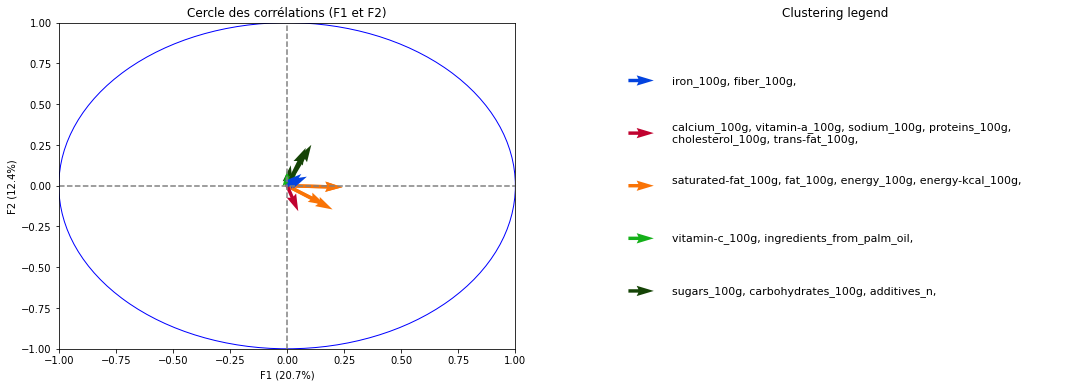

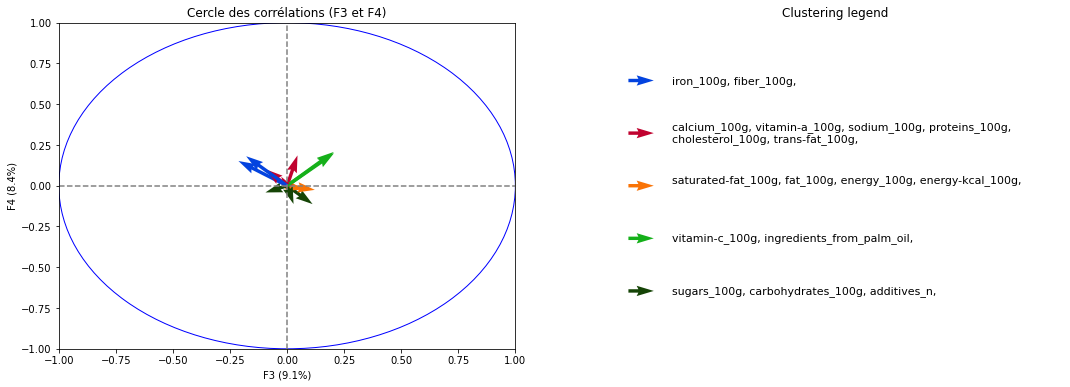

In [22]:
from scipy.cluster.hierarchy import cut_tree
import matplotlib._color_data as mcd
import random

# clustering = pd.Series(cut_tree(Z, height=170).T[0], index=X.columns, dtype="category")
clustering = pd.Series(cut_tree(Z, n_clusters=5).T[0], index=X.columns, dtype="category")
pcs = pca.components_

display_circles(pcs, 4, pca, [(0,1), (2,3)], labels = None, clustering=clustering)


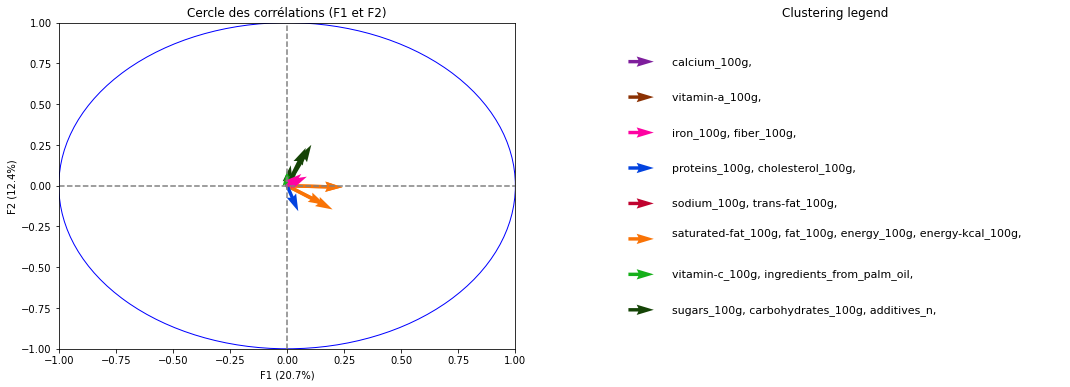

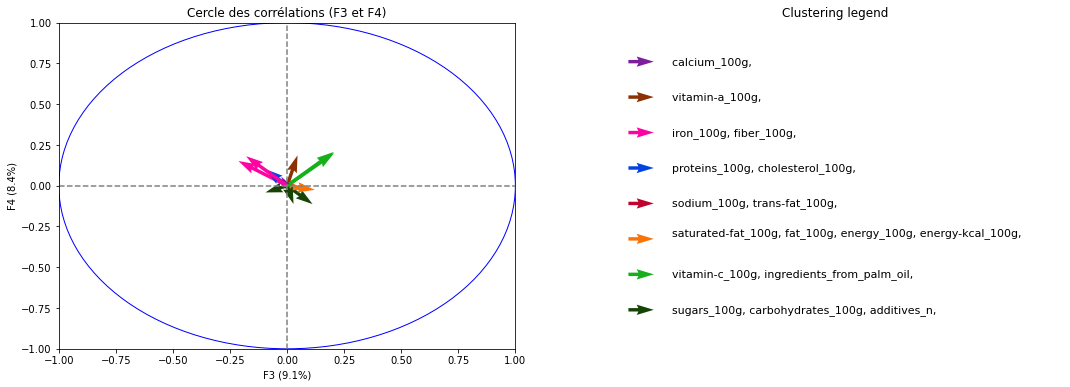

In [23]:
clustering = pd.Series(cut_tree(Z, n_clusters=8).T[0], index=X.columns, dtype="category")
display_circles(pcs, 4, pca, [(0,1), (2,3)], labels = None, clustering=clustering)


The arrow are far away from the circle, so the variables are not weel represented in this projection. The color allow us to see that the clustering of variables is kept, while projecting on the PCA axis. 

###  2.2.2. Focus on representation of products in pca axis : 
Now, let's focus on the projection of individuals onto the pca axis. In the same way, I wan to be able to put a clustering/a coloration on this plot. In deed, it would be a good way to see if in this projection, the nutri-score is well separated (it may not be at all, seeing the correlation heatmap).

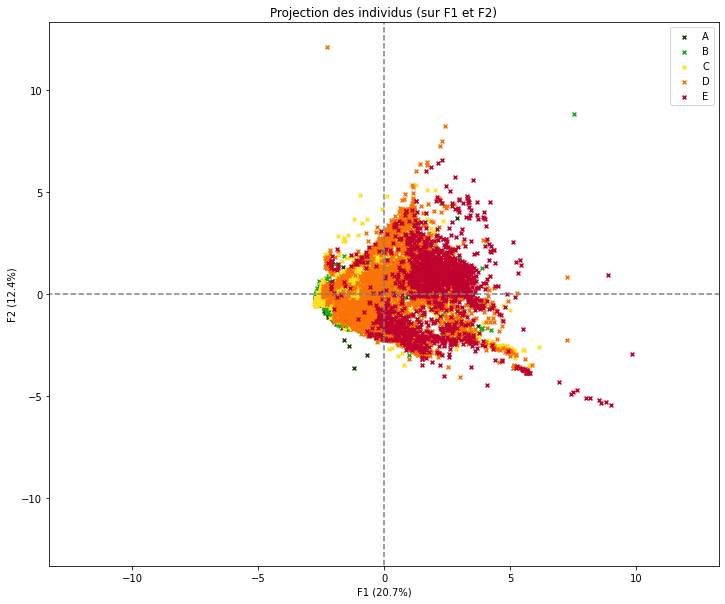

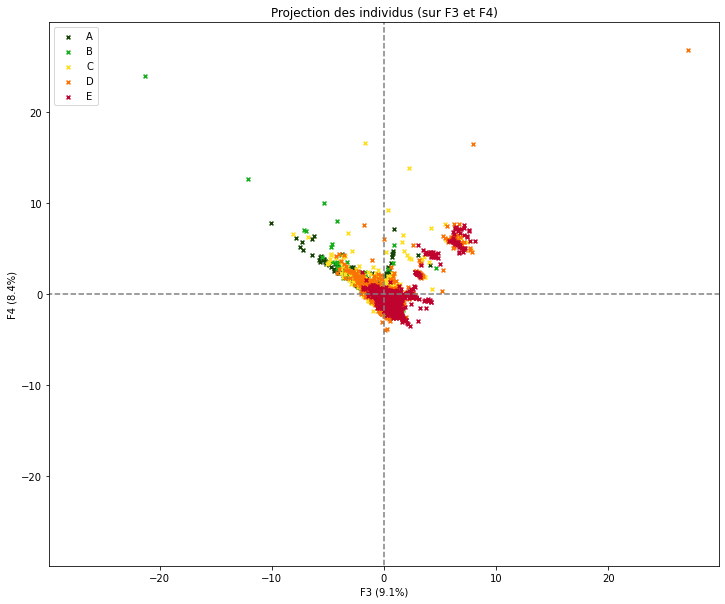

In [24]:
X_projected = pca.transform(X_scaled)
X_projected = pd.DataFrame(X_projected, index = X.index, 
                           columns = ["Axis"+ str(k) for k in np.arange(1,X_projected.shape[1]+1)])
n_comp = 4
# pca = 
axis_ranks =  [(0,1), (2,3)]
ind_labels=None
alpha=1
clustering = data2["score"]

def display_factorial_planes(X_projected, n_comp, pca, axis_ranks, alpha=1, clustering = None):
    # args are as defined just above 
    plot_kwargs = {"marker":"x", "alpha":alpha, 's':15}#, "label" : clustering.values.categories}
    # set dict of color if clustering : 
    if clustering is not None : 
        ## add yellow in color to match with nutri-score : (yellow = '#ffdf22')
        my_color_set = ['#154406', '#15b01a', '#ffdf22', '#f97306', '#c0022f',
                        '#0343df', '#fe02a2', '#8b3103', '#7e1e9c', '#017371',
                        '#380282', '#6b8ba4', '#75bbfd', '#ff81c0', '#c79fef',
                        '#ff073a', '#fdaa48', '#fea993', '#fe7b7c', '#c20078',
                        '#029386', '#677a04', '#b25f03', '#070d0d', '#ffdf22']
        corresp_color_dict = dict(zip(clustering.values.categories, my_color_set))

    for d1,d2 in axis_ranks:
        if d2 < n_comp:
            ax1 = "Axis"+ str(d1+1)
            ax2 = "Axis"+ str(d2+1)
            # initialisation de la figure       
            fig = plt.figure(figsize=(12,10))
            if clustering is not None :
                for k in clustering.values.categories:
                    cluster_index = clustering[clustering==k].index
    #                 print(X_projected.loc[cluster_index, ax1])
                    plt.scatter(X_projected.loc[cluster_index, ax1],X_projected.loc[cluster_index, ax2], 
                                color=corresp_color_dict[k], label = k, **plot_kwargs)
                    plt.legend()

            else : 
                plt.scatter(X_projected[ax1], X_projected[ax2], **plot_kwargs)
            # affichage des labels des points
            if ind_labels is not None:
                for i,(x,y) in enumerate(X_projected[:,[d1,d2]]):
                    plt.text(x, y, ind_labels[i],
                              fontsize='14', ha='center',va='center') 

            # détermination des limites du graphique
            boundary = np.max(np.abs(X_projected.values[:, [d1,d2]])) * 1.1
            plt.xlim([-boundary,boundary])
            plt.ylim([-boundary,boundary])

            # affichage des lignes horizontales et verticales
            plt.plot([-100, 100], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-100, 100], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Projection des individus (sur F{} et F{})".format(d1+1, d2+1))
            plt.show(block=False)
display_factorial_planes(X_projected, n_comp, pca, axis_ranks, alpha=1, clustering = clustering)

There are too many products to see anything on this plot, even when I reduce the size of the marker. To see something, let's plot score by score, on the 2 firsts axis : 

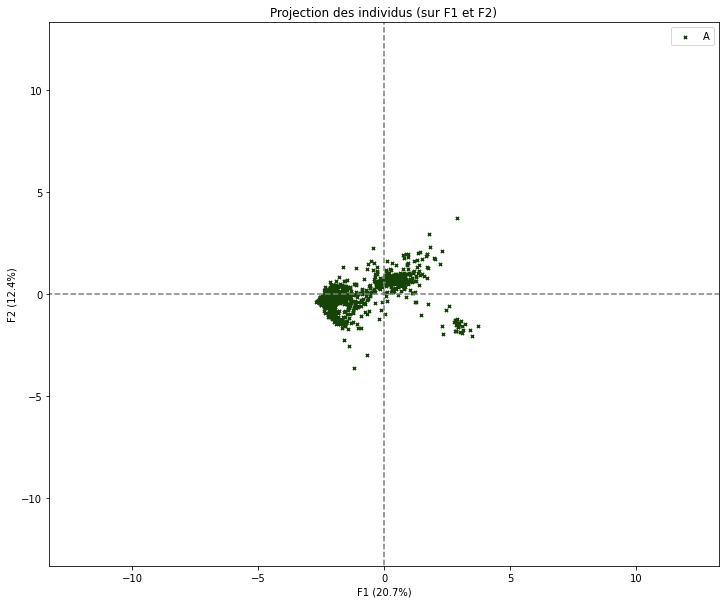

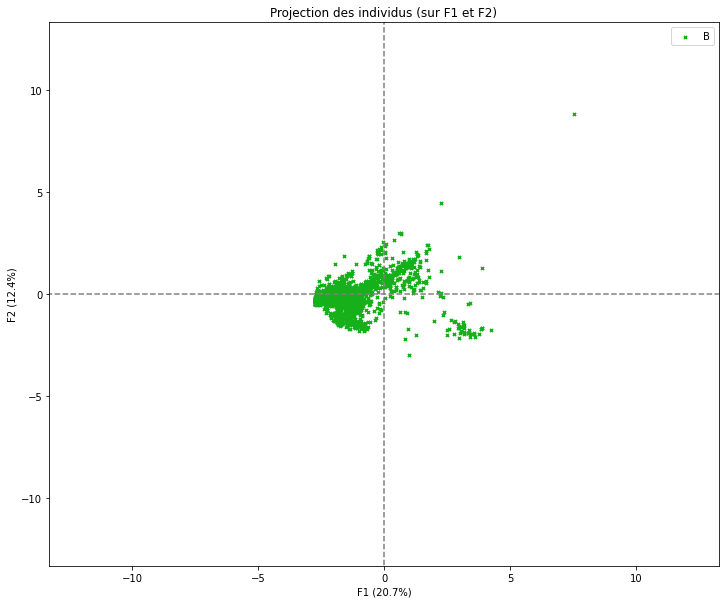

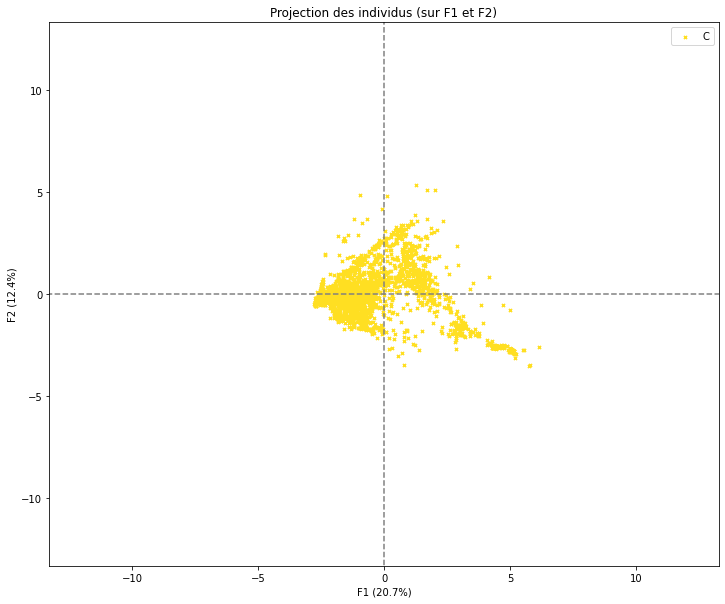

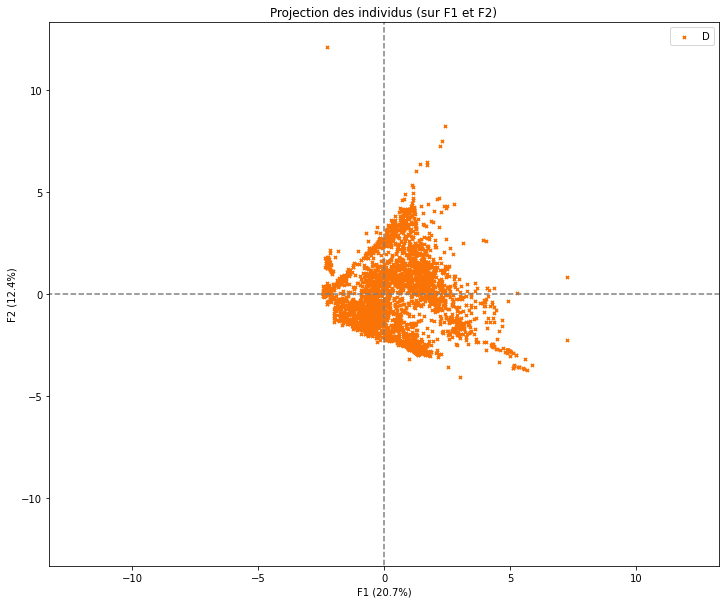

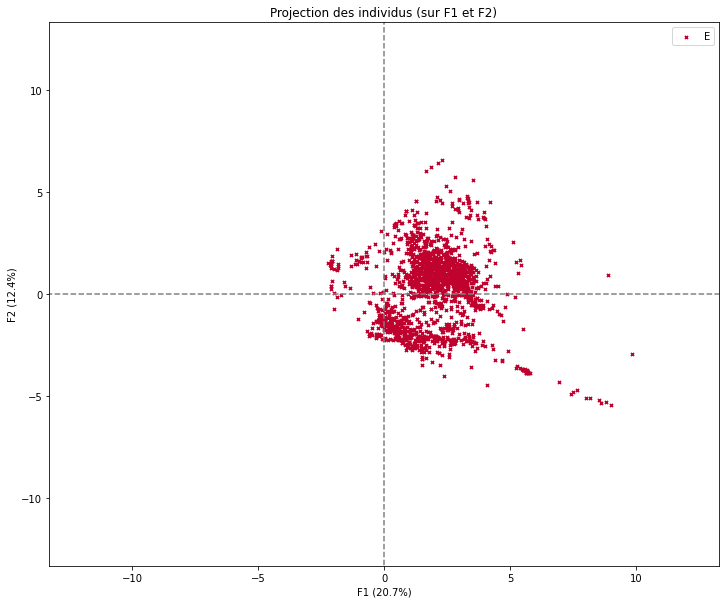

In [25]:
axis_ranks =  [(0,1)]

# args are as defined just above 
plot_kwargs = {"marker":"x", "alpha":alpha, 's':10}#, "label" : clustering.values.categories}
# set dict of color if clustering : 
if clustering is not None : 
    ## add yellow in color to match with nutri-score : (yellow = '#ffdf22')
    my_color_set = ['#154406', '#15b01a', '#ffdf22', '#f97306', '#c0022f',
                    '#0343df', '#fe02a2', '#8b3103', '#7e1e9c', '#017371',
                    '#380282', '#6b8ba4', '#75bbfd', '#ff81c0', '#c79fef',
                    '#ff073a', '#fdaa48', '#fea993', '#fe7b7c', '#c20078',
                    '#029386', '#677a04', '#b25f03', '#070d0d', '#ffdf22']
    corresp_color_dict = dict(zip(clustering.values.categories, my_color_set))

for cluster in clustering.values.categories:
    selected_index = clustering[clustering==cluster].index
    sub_X_projected = X_projected.loc[selected_index,:]
    for d1,d2 in axis_ranks:
        if d2 < n_comp:
            ax1 = "Axis"+ str(d1+1)
            ax2 = "Axis"+ str(d2+1)
            # initialisation de la figure       
            fig = plt.figure(figsize=(12,10))

            plt.scatter(sub_X_projected.loc[:, ax1],sub_X_projected.loc[:, ax2], 
                        color=corresp_color_dict[cluster], label = cluster, **plot_kwargs)
            plt.legend()

            # détermination des limites du graphique
            boundary = np.max(np.abs(X_projected.values[:, [d1,d2]])) * 1.1
            plt.xlim([-boundary,boundary])
            plt.ylim([-boundary,boundary])

            # affichage des lignes horizontales et verticales
            plt.plot([-100, 100], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-100, 100], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Projection des individus (sur F{} et F{})".format(d1+1, d2+1))
            plt.show(block=False)


Ok, so it's still hard to see anything : 
* the variables are not that well represented with PCA 
* the scores does not seem to be well separated in the two first axis of PCA.

**Improvment : first merge variables clustered by hierarchical clustering, before computing PCA**

I decided to use an ANOVA to see if the correlation between the nutrition information and the letter the nutri-score is significative, projected on my pca axis.

In [26]:
X_pca = pd.concat((X_projected,data2["score"]),axis=1)
X_pca.head()
X_pca.dtypes

Axis1     float64
Axis2     float64
Axis3     float64
Axis4     float64
Axis5     float64
Axis6     float64
score    category
dtype: object

## 2.3. ANOVA 

So I have my different variables and my modalities, let's plot a box plot on the projected variable 

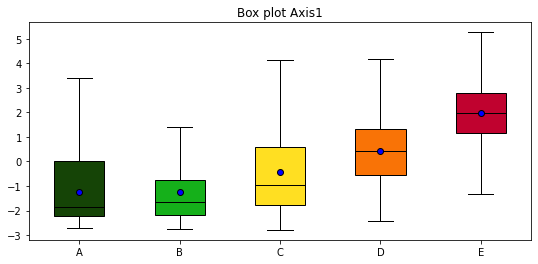

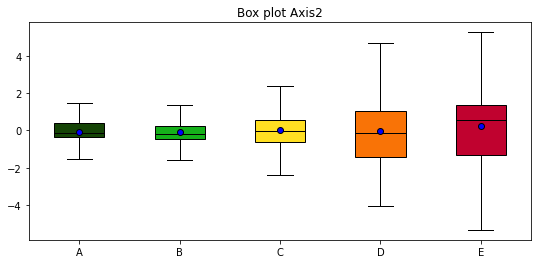

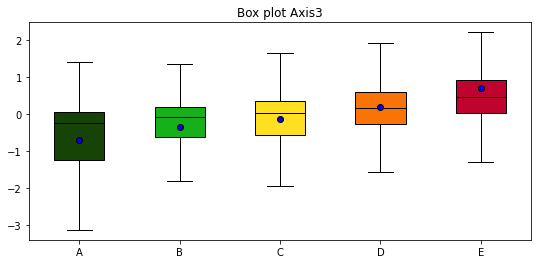

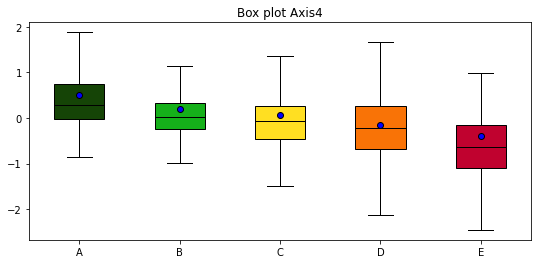

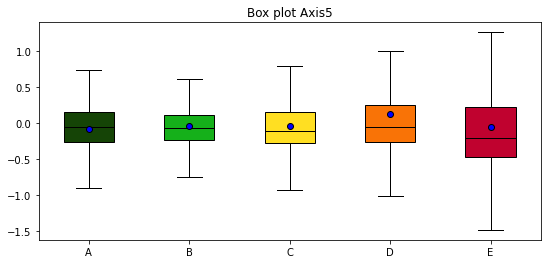

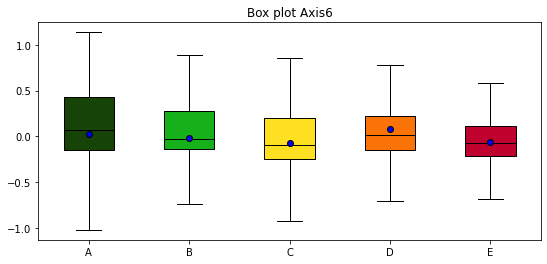

In [27]:
modality_var = "score"
var = "Axis1"
# data = X_pca

def plot_boxplot(data,modality_var, var):
    groupes = []
    modalites = X_pca[modality_var].values.categories
    for m in modalites:
        groupes.append(data[data["score"]==m][var])

    # Propriétés graphiques 
    medianprops = {'color':"black"}
    meanprops = {'marker':'o', 'markeredgecolor':'black','markerfacecolor':'blue'}

    fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(9,4))
    # box plot : 
    boxplot = ax.boxplot(groupes, labels=modalites, showfliers=False, medianprops=medianprops, 
                vert=True, patch_artist=True, showmeans=True, meanprops=meanprops)
    ax.set_title(str("Box plot "+var))
    # add color : 
    for patch, color in zip(boxplot['boxes'], my_color_set):
        patch.set_facecolor(color)
    plt.show()
for k in range(6):
    ax = "Axis"+ str(k+1)
    plot_boxplot(X_pca,modality_var, ax) 


**comment box plot here**

Let's look at the ANOVA :

$$\eta^2 = \frac{\text{Var}_{\text{interclass}}}{\text{Var}_{\text{totale}}} $$

In [28]:
def eta_squared(x,y):
    moyenne_y = y.mean()
    mean_by_mod = y.mean()
    classes = []
    for classe in x.unique():
        yi_classe = y[x==classe]
        classes.append({'ni': len(yi_classe),
                        'moyenne_classe': yi_classe.mean()})
    SCT = sum([(yj-moyenne_y)**2 for yj in y])
    SCE = sum([c['ni']*(c['moyenne_classe']-moyenne_y)**2 for c in classes])
    return SCE/SCT

for k in range(6):
    ax = "Axis"+ str(k+1)
    print("eta² ", ax, " = ",  eta_squared(X_pca["score"],X_pca[ax]))

eta²  Axis1  =  0.3417195909843267
eta²  Axis2  =  0.00579385041822161
eta²  Axis3  =  0.11422005439010617
eta²  Axis4  =  0.051033867287641636
eta²  Axis5  =  0.006398838409013024
eta²  Axis6  =  0.003707947374460319


The [OC class](https://openclassrooms.com/fr/courses/4525266-decrivez-et-nettoyez-votre-jeu-de-donnees/4774896-analysez-une-variable-quantitative-et-une-qualitative-par-anova) on that does not go father. 

I fisrt use this [simple tuto](http://www.python-simple.com/python-statsmodels/statsmodels-anova.php). It explains how to compute an ANOVA with the library "statmodels".

In [29]:
# from scipy.stats import f_oneway
import statsmodels.formula.api
import statsmodels.api
## extract data and fit model
fit = statsmodels.formula.api.ols("Axis1 ~ score", data = X_pca).fit()
## compute ANOVA 
table = statsmodels.api.stats.anova_lm(fit)
table

,df,sum_sq,mean_sq,F,PR(>F)
score,4.0,12004.172188,3001.043047,1293.101677,0.0
Residual,9964.0,23124.548858,2.320810,NaN,NaN


In [30]:
## correct heteroscedasticity : 
statsmodels.stats.anova.anova_lm(fit, robust = 'hc3')

,df,sum_sq,mean_sq,F,PR(>F)
score,4.0,12004.172188,3001.043047,1293.101677,0.0
Residual,9964.0,23124.548858,2.320810,NaN,NaN


They use a "turkey HSD" : **(what is it ?) + code error**

In [219]:
# res = statsmodels.stats.multicomp.pairwise_tukeyhsd(X_pca["score"], X_pca["Axis1"], alpha = 0.01)

Then, I went on the [statmodels library documentation](https://www.statsmodels.org/stable/generated/statsmodels.multivariate.manova.MANOVA.html), they put a link to the [following reference](ftp://public.dhe.ibm.com/software/analytics/spss/documentation/statistics/27.0.1/en/client/Manuals/IBM_SPSS_Statistics_Base.pdf)

--> **looks really cool, to read after I had a look at my stat classics**

I decided to plot the pairplot on my pca axis : 

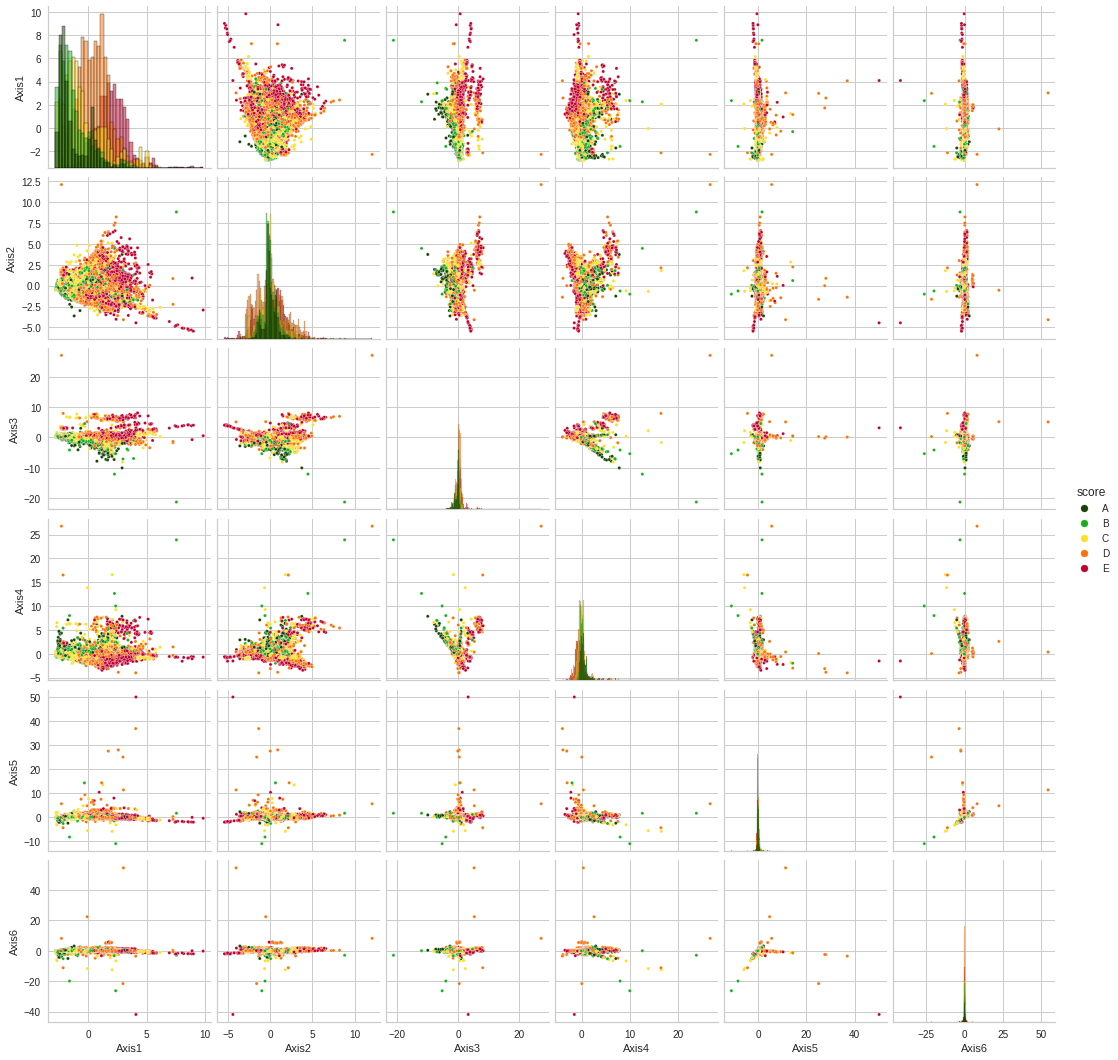

In [220]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Affichage des diagrammes de dispersion
my_palette = {"A": '#154406', "B":'#15b01a', "C":'#ffdf22', "D":'#f97306', "E":'#c0022f'}
# ["Axis"+str(k+1) for k in range(3)] + ["score"]
sns.pairplot(X_pca, hue="score", diag_kind="hist",
             palette=my_palette,plot_kws={"s": 10, "alpha":1})
plt.show()

In [221]:
["Axis"+str(k+1) for k in range(3)] + ["score"]

['Axis1', 'Axis2', 'Axis3', 'score']

# 3. Linear Regression on nutri-score 
Let's see if the nutri-score can be predicted from the nutrition variables.

## 3.1. On original variables
Let's split the standized data : 

In [240]:
from sklearn.model_selection import train_test_split

## DESIGN MATRICES : 
X = data[data.columns.intersection(float_var)]
X = X.drop("nutrition-score-fr_100g",axis = 1, inplace = False)
y = data["nutrition-score-fr_100g"].copy()

## SPLIT DATA 
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)

## STANDARDIZE : 
from sklearn.preprocessing import StandardScaler
my_std = preprocessing.StandardScaler()
my_std.fit(X_train)
X_train_std = my_std.transform(X_train)
X_test_std = my_std.transform(X_test)

## 3.1.1 Yellowbrick library 
With the [routines on yellowbrick](https://www.scikit-yb.org/en/latest/api/regressor/alphas.html#for-estimators-with-built-in-cross-validation) : 

These firsts visualizations are to select the alpha in regression for Ridge and for Lasso :

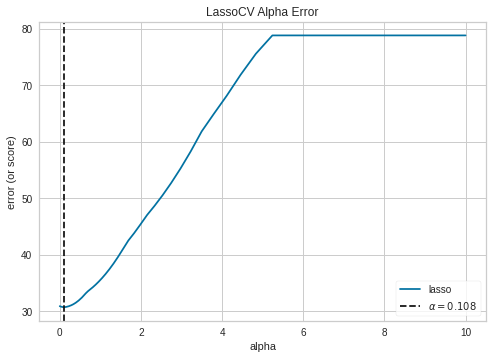

<AxesSubplot:title={'center':'LassoCV Alpha Error'}, xlabel='alpha', ylabel='error (or score)'>

In [293]:
import numpy as np

from sklearn.linear_model import LassoCV
from yellowbrick.regressor import AlphaSelection

# Create a list of alphas to cross-validate against
alphas = np.logspace(-13, 1, 400)

# Instantiate the linear model and visualizer
model = LassoCV(alphas=alphas)
visualizer = AlphaSelection(model)
visualizer.fit(X_train_std, y_train)
visualizer.show()

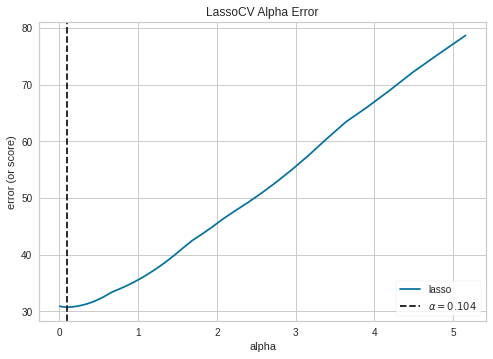

AlphaSelection(ax=<AxesSubplot:title={'center':'LassoCV Alpha Error'}, xlabel='alpha', ylabel='error (or score)'>,
               estimator=LassoCV(random_state=0))

In [294]:
from sklearn.linear_model import LassoCV
from yellowbrick.regressor.alphas import alphas

# Use the quick method and immediately show the figure
alphas(LassoCV(random_state=0), X_train_std, y_train)

### 3.1.2 With my function from the OC tp
In the course on [linear predictive models](https://openclassrooms.com/fr/courses/4444646-entrainez-un-modele-predictif-lineaire/4507811-tp-comparez-le-comportement-du-lasso-et-de-la-regression-ridge), there was a topo on the comparision of the different penalties on linear regression. 
Just for the recall of the notations : 
* Linear Regression : <font color='grey'>$ y = X\beta + \varepsilon$</font>.
* Ridge Regression : <font color='grey'>$ y = X\beta + \varepsilon \text{ under constraint } \|\beta \|_2^2 = 1$</font>.
It rewrites (under KKT)  <font color='grey'>$\underset{\beta \in  R^{p+1}}{\min} (y-X\beta)^T (y-X\beta) + \alpha  \|\beta \|_2^2 $</font>.
* Lasso Regression : <font color='grey'>$ y = X\beta + \varepsilon \text{ under constraint } \|\beta \|_1 = 1$</font>.
It rewrites (under KKT)  <font color='grey'>$\underset{\beta \in  R^{p+1}}{\min} (y-X\beta)^T (y-X\beta) + \alpha  \|\beta \|_1 $</font>.
* Elastic Net Regression : <font color='grey'>$ y = X\beta + \varepsilon \text{ under constraint } \|\beta \|_2^2 = 1, \| \beta \|_1 = 1 \; $</font>.                                               
It rewrites (under KKT)  <font color='grey'>$\underset{\beta \in  R^{p+1}}{\min} (y-X\beta)^T (y-X\beta) + \alpha  \|\beta \|_2^2 + (1-\alpha)  \|\beta \|_1 $</font>.

In [295]:
from sklearn import linear_model
score = "r2"
# score_name = "neg_mean_squared_error"
alpha_values = np.logspace(-1, 5, 50)

##
## SIMPLE LINEAR REGRESSION  :
## 
lr = linear_model.LinearRegression()
lr.fit(X_train_std, y_train)
lr_y_pred = lr.predict(X_test_std)
# on test sample
score_lr = lr.score(X_test_std, y_test)

##
## CV REGRESSION RIDGE : 
##
ridge = linear_model.Ridge()
CV_ridge = model_selection.GridSearchCV(ridge, param_grid={"alpha":alpha_values},
                                         scoring=score_name,cv=5)
CV_ridge.fit(X_train_std, y_train)
score_ridge = CV_ridge.cv_results_['mean_test_score']
alpha_ridge = CV_ridge.best_params_["alpha"]

## 
## CV LASSO REGRESSION : 
##
lasso = linear_model.Lasso()
## CROSS VALIDATION LASSO TO SET ALPHA : 
CV_lasso = model_selection.GridSearchCV(lasso, param_grid = {"alpha":alpha_values}, 
                                        scoring=score_name,cv=5)
CV_lasso.fit(X_train_std, y_train)
score_lasso = CV_lasso.cv_results_['mean_test_score']
alpha_lasso = CV_lasso.best_params_["alpha"]

## 
## CV LASSO REGRESSION : 
##
enet = linear_model.ElasticNet()
## CROSS VALIDATION LASSO TO SET ALPHA : 
CV_enet = model_selection.GridSearchCV(enet, param_grid = {"alpha":alpha_values}, 
                                        scoring=score_name,cv=5)
CV_enet.fit(X_train_std, y_train)
score_enet = CV_enet.cv_results_['mean_test_score']
alpha_enet = CV_enet.best_params_["alpha"]

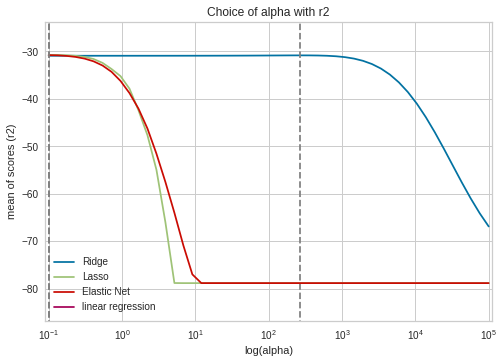

alpha ridge =  268.26957952797244
alpha lasso =  0.1
alpha elactic net =  0.1


In [296]:

## PLOT R2 ERROR :
def score_plot(alpha_values, score, label = None, best_alpha =None, score_name = None) :
    ax = plt.gca()
    ax.set_xscale("log")
    if sum(score<=-100)>1:
        subset = np.where(score>=-100)
        alpha_values= alpha_values[subset]
        score = score[subset]
        
    ax.plot(alpha_values, score, label = label)
    ax.set_xlabel("log(alpha)")
    ax.set_ylabel("mean of scores ("+ str(score_name)+")")
    ax.set_title("Choice of alpha with " +str(score_name))
    ax.set_xlim([0.9*min(alpha_values),1.1*max(alpha_values)])
    if best_alpha is not None : 
        ax.plot([best_alpha,best_alpha], [-100, 100], 
                color="grey", linestyle="dashed")
        
score_plot(alpha_values, score_ridge, "Ridge", alpha_ridge, score)
score_plot(alpha_values, score_lasso, "Lasso", alpha_lasso, score) 
score_plot(alpha_values, score_enet, "Elastic Net", alpha_enet, score) 

## add linear regression R2 line : 
plt.plot([alpha_values[0],alpha_values[-1]], [score_lr, score_lr], label = "linear regression")
plt.ylim([max(1.1*min(min(score_ridge), min(score_lasso), min(score_enet))-0.1,-100), 
          1.1*max(max(score_ridge), max(score_lasso), max(score_enet))+10])
plt.legend()

plt.show()
print("alpha ridge = ", alpha_ridge)
print("alpha lasso = ", alpha_lasso)
print("alpha elactic net = ", alpha_enet)

The results does not seem good, I think it is because the variable are not enought correlated. Let's use the heatmap plot to select the most correlated variables :

In [297]:
selected_var = abs(corr["nutrition-score-fr_100g"]).sort_values(ascending=False)[1:12].index
selected_var = np.concatenate((float_var,selected_var))

In [298]:
selected_var = abs(corr["nutrition-score-fr_100g"]).sort_values(ascending=False)[1:12].index

## DESIGN MATRICES : 
X = data[selected_var]
y = data["nutrition-score-fr_100g"].copy()

## SPLIT DATA 
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)

## STANDARDIZE : 
from sklearn.preprocessing import StandardScaler
my_std = preprocessing.StandardScaler()
my_std.fit(X_train)
X_train_std = my_std.transform(X_train)
X_test_std = my_std.transform(X_test)

In [299]:
score = "r2"
# score_name = "neg_mean_squared_error"
alpha_values = np.logspace(-1, 5, 50)

##
## SIMPLE LINEAR REGRESSION  :
## 
lr = linear_model.LinearRegression()
lr.fit(X_train_std, y_train)
lr_y_pred = lr.predict(X_test_std)
# on test sample
score_lr = lr.score(X_test_std, y_test)

##
## CV REGRESSION RIDGE : 
##
ridge = linear_model.Ridge()
CV_ridge = model_selection.GridSearchCV(ridge, param_grid={"alpha":alpha_values},
                                         scoring=score_name,cv=5)
CV_ridge.fit(X_train_std, y_train)
score_ridge = CV_ridge.cv_results_['mean_test_score']
alpha_ridge = CV_ridge.best_params_["alpha"]

## 
## CV LASSO REGRESSION : 
##
lasso = linear_model.Lasso()
## CROSS VALIDATION LASSO TO SET ALPHA : 
CV_lasso = model_selection.GridSearchCV(lasso, param_grid = {"alpha":alpha_values}, 
                                        scoring=score_name,cv=5)
CV_lasso.fit(X_train_std, y_train)
score_lasso = CV_lasso.cv_results_['mean_test_score']
alpha_lasso = CV_lasso.best_params_["alpha"]

## 
## CV LASSO REGRESSION : 
##
enet = linear_model.ElasticNet()
## CROSS VALIDATION LASSO TO SET ALPHA : 
CV_enet = model_selection.GridSearchCV(enet, param_grid = {"alpha":alpha_values}, 
                                        scoring=score_name,cv=5)
CV_enet.fit(X_train_std, y_train)
score_enet = CV_enet.cv_results_['mean_test_score']
alpha_enet = CV_enet.best_params_["alpha"]

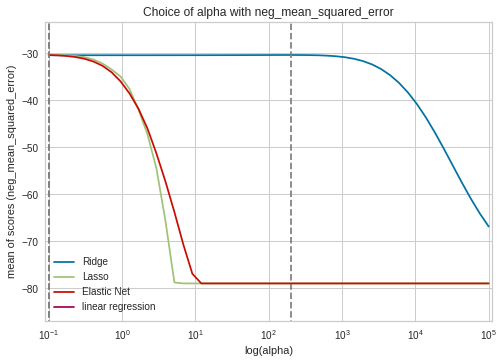

alpha ridge =  202.35896477251575
alpha lasso =  0.1
alpha elactic net =  0.1


In [300]:
score_plot(alpha_values, score_ridge, "Ridge", alpha_ridge, score_name)
score_plot(alpha_values, score_lasso, "Lasso", alpha_lasso, score_name) 
score_plot(alpha_values, score_enet, "Elastic Net", alpha_enet, score_name) 

## add linear regression R2 line : 
plt.plot([alpha_values[0],alpha_values[-1]], [score_lr, score_lr], label = "linear regression")
plt.ylim([max(1.1*min(min(score_ridge), min(score_lasso), min(score_enet))-0.1,-100), 
          1.1*max(max(score_ridge), max(score_lasso), max(score_enet))+10])
plt.legend()

plt.show()
print("alpha ridge = ", alpha_ridge)
print("alpha lasso = ", alpha_lasso)
print("alpha elactic net = ", alpha_enet)

ridge : 


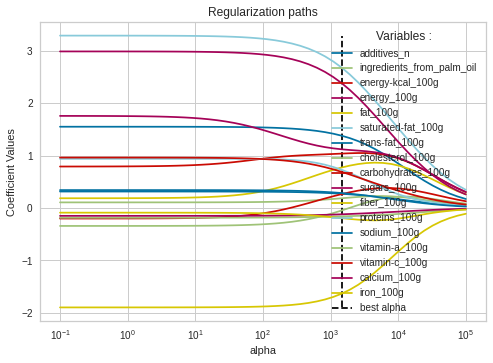

lasso : 


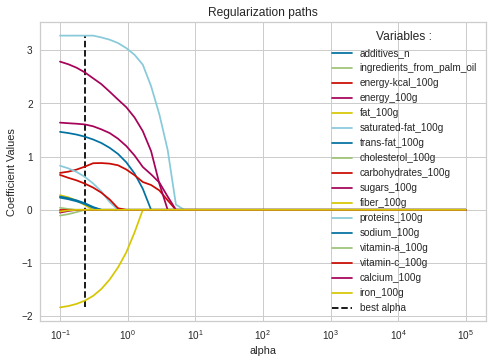

Elastic Net : 


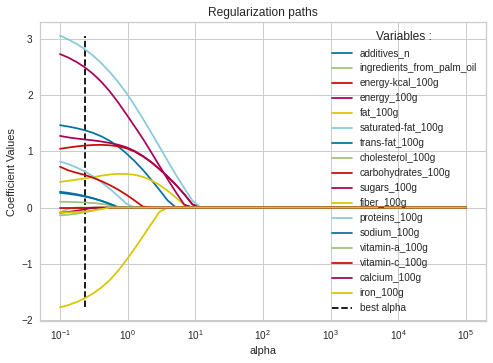

In [261]:
lm_model = lasso
X_ = X_train_std
y_ = y_train
var_names = X.columns
best_alpha = None

## REGULARIZATION PATH :
def plot_regul_paths(alpha_values, lm_model, X_, y_, var_names = None, best_alpha= None):
    regulation_paths = []
    for alpha in alpha_values:
        lm_model.set_params(alpha = alpha)
        lm_model.fit(X_,y_)
        coeffs = lm_model.coef_
        regulation_paths.append(coeffs)
    ## PLOT REG. PÄTHS :
    ax = plt.gca()
    ax.set_xscale("log")
    ax.plot(alpha_values, regulation_paths)
    ## VERTICAL LINE WITH THE BEST ALPHA :
    if best_alpha is not None : 
        ax.vlines(best_alpha, ymin = np.min(regulation_paths), ymax = np.max(regulation_paths), 
                  color = "black", linestyle="dashed", label="best_alpha")
    ## LEGEND :
    if var_names is not None :
        plt.legend(np.concatenate((np.array(var_names),['best alpha'])),
                   title = "Variables :")
    else : 
        plt.legend(var_names, title = "Variables :")
    plt.xlabel("alpha")
    plt.ylabel("Coefficient Values")
    plt.title("Regularization paths")
    plt.show()

print("ridge : ")
plot_regul_paths(alpha_values = alpha_values, lm_model = ridge, 
                 X_ = X_train_std, y_ = y_train,
                 var_names = X.columns, best_alpha = alpha_ridge)
print("lasso : ")
plot_regul_paths(alpha_values = alpha_values, lm_model = lasso, 
                 X_ = X_train_std, y_ = y_train,
                 var_names = X.columns, best_alpha = alpha_lasso)
print("Elastic Net : ")
plot_regul_paths(alpha_values = alpha_values, lm_model = enet, 
                 X_ = X_train_std, y_ = y_train,
                 var_names = X.columns, best_alpha = alpha_enet)


## 3.1. On PCA variable 
Let's split the standized data : 

In [ ]:
from sklearn.model_selection import train_test_split

## DESIGN MATRICES : 
X = X_projected.copy()
y = data["nutrition-score-fr_100g"].copy()

## SPLIT DATA 
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)

## STANDARDIZE : 
from sklearn.preprocessing import StandardScaler
my_std = preprocessing.StandardScaler()
my_std.fit(X_train)
X_train_std = my_std.transform(X_train)
X_test_std = my_std.transform(X_test)

## 3.1.1 Yellowbrick library 


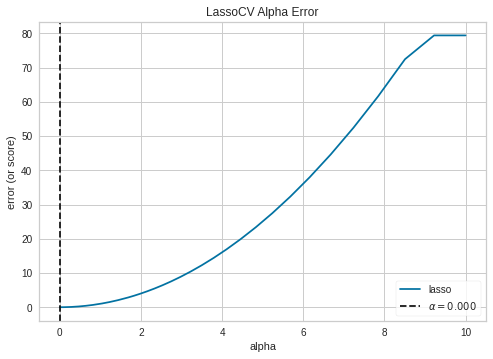

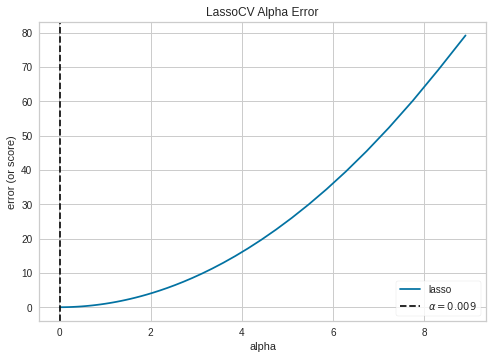

AlphaSelection(ax=<AxesSubplot:title={'center':'LassoCV Alpha Error'}, xlabel='alpha', ylabel='error (or score)'>,
               estimator=LassoCV(random_state=0))

In [212]:
import numpy as np

from sklearn.linear_model import LassoCV
from yellowbrick.regressor import AlphaSelection

# Create a list of alphas to cross-validate against
alphas = np.logspace(-13, 1, 400)

# Instantiate the linear model and visualizer
model = LassoCV(alphas=alphas)
visualizer = AlphaSelection(model)
visualizer.fit(X_train_std, y_train)
visualizer.show()

from sklearn.linear_model import LassoCV
from yellowbrick.regressor.alphas import alphas

# Use the quick method and immediately show the figure
alphas(LassoCV(random_state=0), X_train_std, y_train)

### 3.1.2 With my function from the OC tp

In [213]:
from sklearn import linear_model
##
## SIMPLE LINEAR REGRESSION  :
## 
lr = linear_model.LinearRegression()
lr.fit(X_train_std, y_train)
lr_y_pred = lr.predict(X_test_std)
# on test sample
R2_lr = lr.score(X_test_std, y_test)

##
## CV REGRESSION RIDGE : 
##
ridge = linear_model.Ridge()
alpha_values = np.logspace(-1, 5, 50)
CV_ridge = model_selection.GridSearchCV(ridge, param_grid={"alpha":alpha_values},
                                         scoring="r2",cv=5)
CV_ridge.fit(X_train_std, y_train)
R2_ridge = CV_ridge.cv_results_['mean_test_score']
alpha_ridge = CV_ridge.best_params_["alpha"]

## 
## CV LASSO REGRESSION : 
##
lasso = linear_model.Lasso()
## CROSS VALIDATION LASSO TO SET ALPHA : 
CV_lasso = model_selection.GridSearchCV(lasso, param_grid = {"alpha":alpha_values}, 
                                        scoring="r2",cv=5)
CV_lasso.fit(X_train_std, y_train)
R2_lasso = CV_lasso.cv_results_['mean_test_score']
alpha_lasso = CV_lasso.best_params_["alpha"]

## 
## CV LASSO REGRESSION : 
##
enet = linear_model.ElasticNet()
## CROSS VALIDATION LASSO TO SET ALPHA : 
CV_enet = model_selection.GridSearchCV(enet, param_grid = {"alpha":alpha_values}, 
                                        scoring="r2",cv=5)
CV_enet.fit(X_train_std, y_train)
R2_enet = CV_enet.cv_results_['mean_test_score']
alpha_enet = CV_enet.best_params_["alpha"]

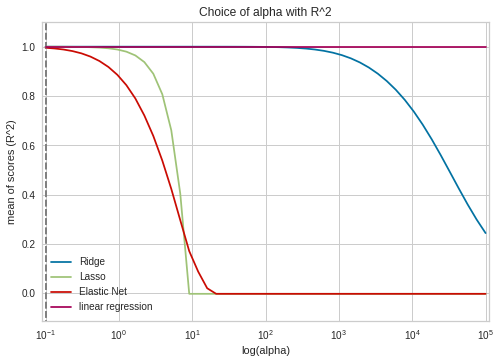

In [216]:
R2_plot(alpha_values, R2_ridge, "Ridge", alpha_ridge)
R2_plot(alpha_values, R2_lasso, "Lasso", alpha_lasso) 
R2_plot(alpha_values, R2_enet, "Elastic Net", alpha_enet) 

## add linear regression R2 line : 
plt.plot([alpha_values[0],alpha_values[-1]], [R2_lr, R2_lr], label = "linear regression")
plt.ylim([1.1*min(min(R2_ridge)-0.1, min(R2_lasso)-0.1), 1.1*max(max(R2_ridge), max(R2_lasso))])
plt.legend()

plt.show()

ridge : 


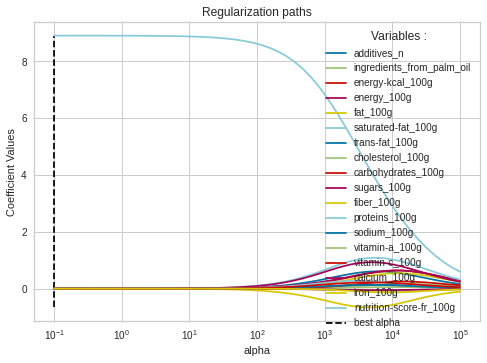

lasso : 


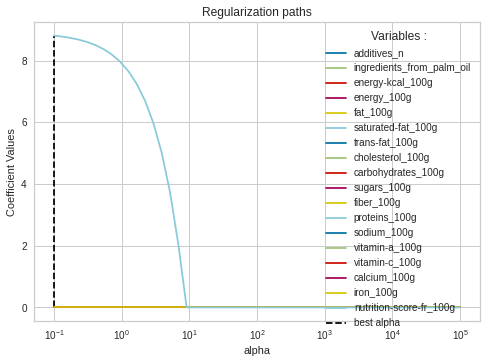

Elastic Net : 


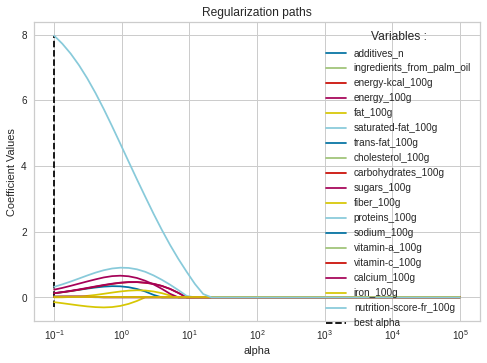

In [215]:
print("ridge : ")
plot_regul_paths(alpha_values = alpha_values, lm_model = ridge, 
                 X_ = X_train_std, y_ = y_train,
                 var_names = X.columns, best_alpha = alpha_ridge)
print("lasso : ")
plot_regul_paths(alpha_values = alpha_values, lm_model = lasso, 
                 X_ = X_train_std, y_ = y_train,
                 var_names = X.columns, best_alpha = alpha_lasso)
print("Elastic Net : ")
plot_regul_paths(alpha_values = alpha_values, lm_model = enet, 
                 X_ = X_train_std, y_ = y_train,
                 var_names = X.columns, best_alpha = alpha_enet)

In [ ]:
################################################################################

**same code with the problem on legend :**

In [ ]:
# X_projected
n_comp = 4
# pca
axis_ranks =  [(0,1), (2,3)]
ind_labels=None
alpha=1 
illustrative_var="additive_n"
clustering = data["score"]

X_projected = pca.transform(X_scaled)
X_projected = pd.DataFrame(X_projected, index = X.index, 
                           columns = ["Axis"+ str(k) for k in np.arange(1,X_projected.shape[1]+1)])

def display_factorial_planes_pb_legend(X_projected, n_comp, pca, axis_ranks, ind_labels=None, alpha=1, clustering=None):
    plot_kwargs = {"marker":"x", "alpha":alpha}#, "label" : clustering.values.categories}

    if clustering is not None : 
        my_color_set = ['#154406', '#15b01a', '#f97306', '#c0022f',
                        '#0343df', '#fe02a2', '#8b3103', '#7e1e9c', '#017371',
                        '#380282', '#6b8ba4', '#75bbfd', '#ff81c0', '#c79fef',
                        '#ff073a', '#fdaa48', '#fea993', '#fe7b7c', '#c20078',
                        '#029386', '#677a04', '#b25f03', '#070d0d', '#ffdf22']
        corresp_color_dict = dict(zip(clustering.values.categories, my_color_set))
    #     my_color = clustering.values.map(corresp_color_dict)
        plot_kwargs["color"] = clustering.values.map(dict(zip(clustering.values.categories, my_color_set)))
    else :
        plot_kwargs["color"] = "grey"
    for d1,d2 in axis_ranks:
        if d2 < n_comp:
            # initialisation de la figure       
            fig = plt.figure(figsize=(7,6))

            plt.scatter(X_projected.values[:, d1], X_projected.values[:, d2], **plot_kwargs)
            if clustering is not None :
                plt.legend(clustering.values.categories)

            # affichage des labels des points
            if ind_labels is not None:
                for i,(x,y) in enumerate(X_projected.values[:,[d1,d2]]):
                    plt.text(x, y, ind_labels[i],
                              fontsize='14', ha='center',va='center') 

            # détermination des limites du graphique
            boundary = np.max(np.abs(X_projected.values[:, [d1,d2]])) * 1.1
            plt.xlim([-boundary,boundary])
            plt.ylim([-boundary,boundary])

            # affichage des lignes horizontales et verticales
            plt.plot([-100, 100], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-100, 100], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Projection des individus (sur F{} et F{})".format(d1+1, d2+1))
            plt.show(block=False)
display_factorial_planes_pb_legend(X_projected, n_comp, pca, axis_ranks, ind_labels=None, alpha=1)

[a source to dig](ftp://public.dhe.ibm.com/software/analytics/spss/documentation/statistics/27.0.1/fr/client/Manuals/)